**Before starting ...**

Checking we are using **frugal-notebooks-env** conda environment

In [1]:
!which python

/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/bin/python


Checking the python version is 3.9 (compatibility with frugal AI codebase)

In [2]:
!python --version

Python 3.9.21


# Text classification : non neural models

In [3]:
import numpy as np
import pandas as pd

## Let's explore the dataset

**Loading the dataset**

In [4]:
df = pd.read_parquet("hf://datasets/QuotaClimat/frugalaichallenge-text-train/train.parquet")

In [5]:
df.head()

,quote,label,source,url,language,subsource,id
0,"There is clear, compelling evidence that many ...",5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test1,None
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
4,It's going to be 42 here today and the hottest...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None


**We will only use the quote and label columns**

In [6]:
df.columns

Index(['quote', 'label', 'source', 'url', 'language', 'subsource', 'id'], dtype='object')

In [7]:
df = df[['quote', 'label']]
df.head()

,quote,label
0,"There is clear, compelling evidence that many ...",5_science_unreliable
1,"For most of the Holocene (last 10k years), sea...",1_not_happening
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant
4,It's going to be 42 here today and the hottest...,1_not_happening


**The label have 8 classes**

In [8]:
print('unique values:')
print('label\n', df['label'].unique())

unique values:
label
 ['5_science_unreliable' '1_not_happening'
 '4_solutions_harmful_unnecessary' '0_not_relevant' '6_proponents_biased'
 '7_fossil_fuels_needed' '2_not_human' '3_not_bad']


**No duplicate quotes**

In [9]:
df['quote'].duplicated().sum()

0

**But we have a bit of unbalanced classes (that we will have to take care of)**

In [10]:
class_distribution = df['label'].value_counts().sort_index()
df['label'].value_counts(normalize=True).sort_index()

label
0_not_relevant                     0.265638
1_not_happening                    0.121655
2_not_human                        0.115252
3_not_bad                          0.063372
4_solutions_harmful_unnecessary    0.127073
5_science_unreliable               0.131505
6_proponents_biased                0.128386
7_fossil_fuels_needed              0.047119
Name: proportion, dtype: float64

In [11]:
import plotly.express as px

fig = px.bar(x=class_distribution.index, y=class_distribution.values, 
             labels={'x': 'Label', 'y': 'Count'})
fig.update_layout(width=900, height=400, title="Class Distribution")
fig.show(renderer='iframe')

**No missing values**

In [12]:
missing_values = df.isnull().sum()
print(missing_values)

quote    0
label    0
dtype: int64


**We will need to crop some quotes**

In [13]:
df['text_length'] = df['quote'].str.len()
print(df['text_length'].describe())

count    6091.000000
mean      293.528485
std       258.330755
min        19.000000
25%       139.000000
50%       228.000000
75%       365.000000
max      4703.000000
Name: text_length, dtype: float64


In [14]:
fig = px.histogram(df, x='text_length', nbins=50)
fig.update_layout(width=800, height=300, title="Sentence Length Distribution")
fig.show(renderer='iframe')

In [15]:
threshold = np.percentile(df['text_length'], 90)
threshold

544.0

In [16]:
long_quotes = df[df['text_length'] > threshold]
print('Number of quotes above threshold: ', long_quotes.shape[0])

Number of quotes above threshold:  608


In [17]:
df['truncated_quote'] = df['quote'].str.slice(0, int(threshold))
df.head()

,quote,label,text_length,truncated_quote
0,"There is clear, compelling evidence that many ...",5_science_unreliable,277,"There is clear, compelling evidence that many ..."
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,279,"For most of the Holocene (last 10k years), sea..."
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,286,"China, which hosts U.N. climate talks next wee..."
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,146,And the fabricated documents (which Dr. Mann a...
4,It's going to be 42 here today and the hottest...,1_not_happening,123,It's going to be 42 here today and the hottest...


## Preprocessing

**What will need to be done:**
- pre-cleaning : strip, split, lowercase, numbers, punctuation/symbols, special chars, URLs
- tokenizing | NLTK.tokenize
- stopwords : irrelevant frequent words | nltk.corpus stopwords
- lemmatizing/stemming : word roots | nltk.stem - WordNetLemmatizer
- vectorizing options
    - Bag-of-words (CountVectorizer) counting : word order, doc len, doc context not taken into account
    - Tf-idf (TdidfVectorizer) weighting : word order, doc context not taken into account
        - min_df (infrequent words)
        - max_df (frequent words)
        - max_features (curse of dimensionality)
        - ngram_range = (min_n, max_n) (capturing the context of the words)

**Features and target**

In [18]:
X = df['quote']
y = df['label']
X.shape, y.shape

((6091,), (6091,))

In [19]:
def print_head(df):
    for i in range(3):
        print(i, df[i], '\n')
    print('shape:',df.shape)
print_head(X)

0 There is clear, compelling evidence that many of the major conclusions of the IPCC, your new religions constantly-changing Holy Book, are based on evidence that has been fabricated. The hockey stick graph that purported to abolish the mediaeval warm period is just one example. 

1 For most of the Holocene (last 10k years), sea level has been rising at a rate of around 2mm per year. Climate change has little to do with it - it's simply a long term inevitability which will end when the current interglacial returns to a glacial period (which we will regret). 

2 China, which hosts U.N. climate talks next week for the first time, is promoting what it calls ambitious plans to boost energy efficiency and curb emissions. But its supercharged growth means even with rapid efficiency gains it cancels out other global efforts to combat climate change. 

shape: (6091,)


**Cleaning**

In [20]:
import string
import re
import contractions
import html
import unicodedata


def basic_cleaning(sentence):

    sentence = html.unescape(sentence)                        # convert html entities
    sentence = re.sub(r'http\S+|www\S+', '', sentence)        # remove URLs
    sentence = unicodedata.normalize('NFKC', sentence)        # normalize Unicode
    sentence = sentence.encode("ascii", "ignore").decode()    # remove non ASCII

    sentence = contractions.fix(sentence)                     # expand contractions
    sentence = sentence.lower()

    sentence = re.sub(r'\d+', '', sentence)                   # remove digits

    punctuation = string.punctuation.replace("-", "")         # we keep hyphens
    translator = str.maketrans('', '', punctuation)
    sentence = sentence.translate(translator)                 # remove punctuation
    sentence = re.sub(r'\s-\s', ' ', sentence)                # removes " - " (hyphen surrounded by spaces)
    sentence = re.sub(r'\s-', ' ', sentence)                  # removes leading hyphens
    sentence = re.sub(r'-\s', ' ', sentence)                  # removes trailing hyphens

    sentence = ' '.join(sentence.split()).strip()             # remove whitespace
    return sentence

In [21]:
X_clean = X.apply(basic_cleaning)
print_head(X_clean)

0 there is clear compelling evidence that many of the major conclusions of the ipcc your new religions constantly-changing holy book are based on evidence that has been fabricated the hockey stick graph that purported to abolish the mediaeval warm period is just one example 

1 for most of the holocene last k years sea level has been rising at a rate of around mm per year climate change has little to do with it it is simply a long term inevitability which will end when the current interglacial returns to a glacial period which we will regret 

2 china which hosts youn climate talks next week for the first time is promoting what it calls ambitious plans to boost energy efficiency and curb emissions but its supercharged growth means even with rapid efficiency gains it cancels out other global efforts to combat climate change 

shape: (6091,)


**Tokenizing**

In [22]:
import nltk
from nltk.tokenize import word_tokenize

In [23]:
# nltk_path = "/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/nltk_data"
# nltk.download('punkt_tab', download_dir=nltk_path)

In [24]:
X_tokenized = X_clean.apply(word_tokenize)
print_head(X_tokenized)

0 ['there', 'is', 'clear', 'compelling', 'evidence', 'that', 'many', 'of', 'the', 'major', 'conclusions', 'of', 'the', 'ipcc', 'your', 'new', 'religions', 'constantly-changing', 'holy', 'book', 'are', 'based', 'on', 'evidence', 'that', 'has', 'been', 'fabricated', 'the', 'hockey', 'stick', 'graph', 'that', 'purported', 'to', 'abolish', 'the', 'mediaeval', 'warm', 'period', 'is', 'just', 'one', 'example'] 

1 ['for', 'most', 'of', 'the', 'holocene', 'last', 'k', 'years', 'sea', 'level', 'has', 'been', 'rising', 'at', 'a', 'rate', 'of', 'around', 'mm', 'per', 'year', 'climate', 'change', 'has', 'little', 'to', 'do', 'with', 'it', 'it', 'is', 'simply', 'a', 'long', 'term', 'inevitability', 'which', 'will', 'end', 'when', 'the', 'current', 'interglacial', 'returns', 'to', 'a', 'glacial', 'period', 'which', 'we', 'will', 'regret'] 

2 ['china', 'which', 'hosts', 'youn', 'climate', 'talks', 'next', 'week', 'for', 'the', 'first', 'time', 'is', 'promoting', 'what', 'it', 'calls', 'ambitious', 

**Stopwords ??**

In [25]:
from nltk.corpus import stopwords

# nltk.download('stopwords', download_dir=nltk_path)
stop_words = set(stopwords.words('english'))

In [26]:
X_stopwords = X_tokenized.apply(lambda x: [w for w in x if w.lower() not in stop_words])

print_head(X_stopwords)

0 ['clear', 'compelling', 'evidence', 'many', 'major', 'conclusions', 'ipcc', 'new', 'religions', 'constantly-changing', 'holy', 'book', 'based', 'evidence', 'fabricated', 'hockey', 'stick', 'graph', 'purported', 'abolish', 'mediaeval', 'warm', 'period', 'one', 'example'] 

1 ['holocene', 'last', 'k', 'years', 'sea', 'level', 'rising', 'rate', 'around', 'mm', 'per', 'year', 'climate', 'change', 'little', 'simply', 'long', 'term', 'inevitability', 'end', 'current', 'interglacial', 'returns', 'glacial', 'period', 'regret'] 

2 ['china', 'hosts', 'youn', 'climate', 'talks', 'next', 'week', 'first', 'time', 'promoting', 'calls', 'ambitious', 'plans', 'boost', 'energy', 'efficiency', 'curb', 'emissions', 'supercharged', 'growth', 'means', 'even', 'rapid', 'efficiency', 'gains', 'cancels', 'global', 'efforts', 'combat', 'climate', 'change'] 

shape: (6091,)


**Lemmatizing**

In [27]:
from nltk.stem import WordNetLemmatizer

# nltk.download('wordnet', download_dir=nltk_path)

In [28]:
X_lemmatized = X_stopwords.apply(lambda x : [WordNetLemmatizer().lemmatize(w, pos = "v") for w in x])
print_head(X_lemmatized)

0 ['clear', 'compel', 'evidence', 'many', 'major', 'conclusions', 'ipcc', 'new', 'religions', 'constantly-changing', 'holy', 'book', 'base', 'evidence', 'fabricate', 'hockey', 'stick', 'graph', 'purport', 'abolish', 'mediaeval', 'warm', 'period', 'one', 'example'] 

1 ['holocene', 'last', 'k', 'years', 'sea', 'level', 'rise', 'rate', 'around', 'mm', 'per', 'year', 'climate', 'change', 'little', 'simply', 'long', 'term', 'inevitability', 'end', 'current', 'interglacial', 'return', 'glacial', 'period', 'regret'] 

2 ['china', 'host', 'youn', 'climate', 'talk', 'next', 'week', 'first', 'time', 'promote', 'call', 'ambitious', 'plan', 'boost', 'energy', 'efficiency', 'curb', 'emissions', 'supercharge', 'growth', 'mean', 'even', 'rapid', 'efficiency', 'gain', 'cancel', 'global', 'efforts', 'combat', 'climate', 'change'] 

shape: (6091,)


**Vectorizing**

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_lemmatized_text = X_lemmatized.apply(lambda words: " ".join(words))

vectorizer = TfidfVectorizer()
# vectorizer = TfidfVectorizer(ngram_range = (2,2))

X_vectorized = pd.DataFrame(
    vectorizer.fit_transform(X_lemmatized_text).toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_lemmatized.index
)

vocabulary = vectorizer.get_feature_names_out()

word_occurrences = (X_vectorized > 0).sum(axis=0)
word_count = dict(zip(vocabulary, np.asarray(word_occurrences).flatten()))

print(f"\nVocabulary size: {len(vocabulary)}")
print('feature shape:', X_vectorized.shape)
print()
X_vectorized.head(3)


Vocabulary size: 12915
feature shape: (6091, 12915)



,aabe,aabes,ab,abandon,abandoned,abandonment,abate,abatement,abbot,abbott,...,zinke,zipper,zir,zitty,zone,zoom,zoonotic,zurich,zwally,zycher
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Checking preprocessing**

In [30]:
# non alphanum 
alphanum_error = [word for word in vocabulary if re.search(r"[^a-zA-Z0-9'-]", word)]
print("preprocessing alphanum errors:", alphanum_error[:20])
print('---------------')

# case-sensitive duplicates
vocab_lower = set(word.lower() for word in vocabulary)
if len(vocab_lower) != len(vocabulary):
    print("Warning: Vocabulary contains case-sensitive duplicates!")
print('---------------')

# short words and long words
short_words = [word for word in vocabulary if len(word) <= 2]
long_words = [word for word in vocabulary if len(word) > 15]

print('Longest and shortest words:')
print(len(short_words), "short words (≤2 chars):\n", short_words[:20])
print(len(long_words), "long words (>15 chars):\n", long_words[:20])
print('---------------')

# most / least frequent
from collections import Counter

word_count_counter = Counter(word_count)
print("Most common words:\n", word_count_counter.most_common(10))
print("Least common words:\n", word_count_counter.most_common()[-10:])
print('---------------')

# out of vocabulary - not english
#nltk.download('words', download_dir=nltk_path)
from nltk.corpus import words

english_vocab = set(words.words())

oov_words = [word for word in vocabulary if word.lower() not in english_vocab]
print(f"Out-of-vocabulary words: {len(oov_words)}")
print("Sample OOV words:", oov_words[:20])
print('---------------')

preprocessing alphanum errors: []
---------------
---------------
Longest and shortest words:
152 short words (≤2 chars):
 ['ab', 'ac', 'ad', 'ag', 'ah', 'al', 'ao', 'ap', 'ar', 'as', 'at', 'au', 'ax', 'az', 'bc', 'be', 'bi', 'bn', 'bp', 'bs']
120 long words (>15 chars):
 ['absorptionemission', 'absorptivitiesemissivities', 'absorptivityemissivity', 'administrationand', 'administrationto', 'americansespecially', 'americaspowercom', 'americatraditional', 'antidiscrimination', 'antienvironmental', 'authoritarianism', 'baltimorewashington', 'bureaucratically', 'carefullyselected', 'catastrophically', 'centerdeveloping', 'changedismissing', 'characterization', 'characterizations', 'chlorflourocarbon']
---------------
Most common words:
 [('climate', 2177), ('change', 1578), ('warm', 1307), ('global', 1286), ('years', 704), ('say', 686), ('would', 654), ('carbon', 652), ('energy', 646), ('make', 604)]
Least common words:
 [('zemp', 1), ('zinke', 1), ('zipper', 1), ('zir', 1), ('zitty', 1), 

**Let's have a look at the most frequent words**

In [31]:
word_count_counter

Counter({'climate': 2177,
         'change': 1578,
         'warm': 1307,
         'global': 1286,
         'years': 704,
         'say': 686,
         'would': 654,
         'carbon': 652,
         'energy': 646,
         'make': 604,
         'people': 562,
         'one': 550,
         'co': 523,
         'go': 513,
         'science': 511,
         'think': 508,
         'gas': 502,
         'increase': 456,
         'emissions': 452,
         'even': 441,
         'use': 435,
         'time': 434,
         'world': 421,
         'temperature': 418,
         'get': 415,
         'dioxide': 405,
         'like': 404,
         'much': 391,
         'us': 390,
         'earth': 387,
         'need': 380,
         'know': 372,
         'human': 344,
         'many': 342,
         'natural': 337,
         'level': 325,
         'scientific': 322,
         'fuel': 321,
         'cause': 320,
         'rise': 319,
         'take': 315,
         'also': 312,
         'greenhouse': 307,
   

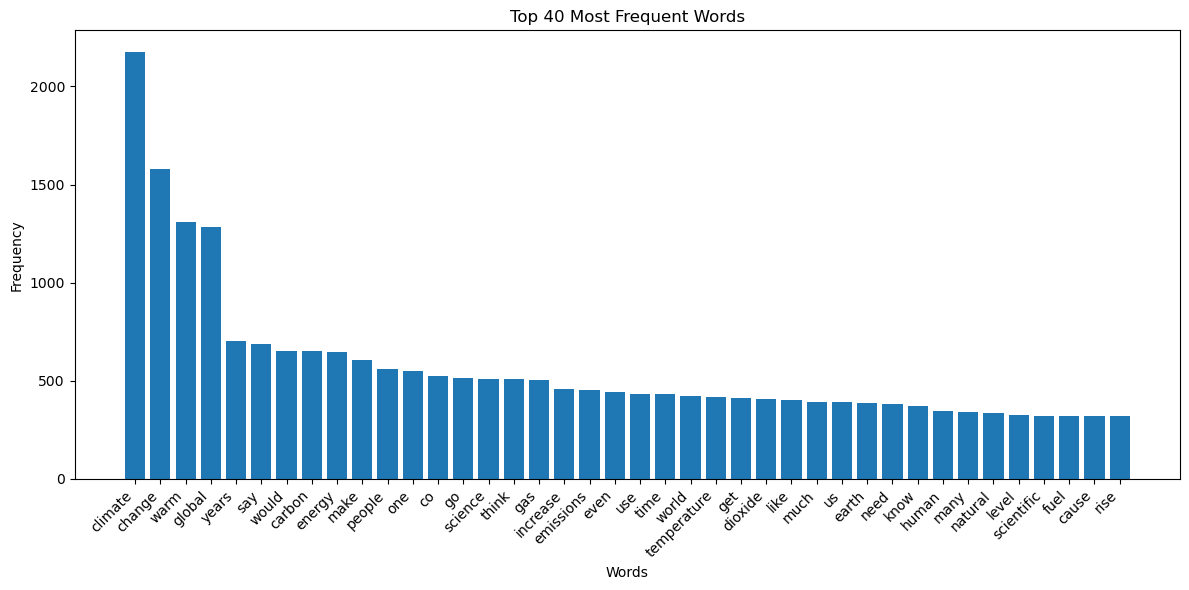


Total words: 141682
Unique words: 12915
Average word frequency: 10.97




In [32]:
import matplotlib.pyplot as plt

top_20_words = word_count_counter.most_common(40)
df_word_freq = pd.DataFrame(top_20_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
plt.bar(df_word_freq['Word'], df_word_freq['Frequency'])
plt.title('Top 40 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

total_words = sum(word_count_counter.values())
unique_words = len(vocabulary)
average_freq = total_words / unique_words

print(f"\nTotal words: {total_words}")
print(f"Unique words: {unique_words}")
print(f"Average word frequency: {average_freq:.2f}")
print()
print()



**Now let's build our model**  
We check our feature and target

In [33]:
X_vectorized

,aabe,aabes,ab,abandon,abandoned,abandonment,abate,abatement,abbot,abbott,...,zinke,zipper,zir,zitty,zone,zoom,zoonotic,zurich,zwally,zycher
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
y

0                  5_science_unreliable
1                       1_not_happening
2       4_solutions_harmful_unnecessary
3                        0_not_relevant
4                       1_not_happening
                     ...               
6431                6_proponents_biased
6432                        2_not_human
6433                     0_not_relevant
6435               5_science_unreliable
6436                    1_not_happening
Name: label, Length: 6091, dtype: object

**Let's encode the target**

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_cat = le.fit_transform(y)
print(le.classes_)
print()
print('y_cat :', y_cat)

['0_not_relevant' '1_not_happening' '2_not_human' '3_not_bad'
 '4_solutions_harmful_unnecessary' '5_science_unreliable'
 '6_proponents_biased' '7_fossil_fuels_needed']

y_cat : [5 1 4 ... 0 5 1]


In [36]:
X_vectorized.shape, y_cat.shape, type(X_vectorized), type(y_cat)

((6091, 12915), (6091,), pandas.core.frame.DataFrame, numpy.ndarray)

**Train test split**

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

print('types', type(X_train), type(X_test), type(y_train), type(y_test))
'Shapes', X_train.shape, X_test.shape, y_train.shape, y_test.shape

types <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


('Shapes', (4872, 12915), (1219, 12915), (4872,), (1219,))

**Check the category split**

In [38]:
total_category_counts = pd.DataFrame(y).value_counts().sort_index()
train_category_counts = pd.DataFrame(y_train).value_counts().sort_index()
test_category_counts = pd.DataFrame(y_test).value_counts().sort_index()

total_proportions = pd.DataFrame(y).value_counts(normalize=True).sort_index().round(2)
train_proportions = pd.DataFrame(y_train).value_counts(normalize=True).sort_index().round(2)
test_proportions = pd.DataFrame(y_test).value_counts(normalize=True).sort_index().round(2)

category_distribution_df = pd.DataFrame({
    "total": total_category_counts.values,
    "train": train_category_counts.values,
    "test": test_category_counts.values,
    "total%": total_proportions.values,
    "train%": train_proportions.values,
    "test%": test_proportions.values
}, index=total_category_counts.index)

print(category_distribution_df)

                                 total  train  test  total%  train%  test%
label                                                                     
0_not_relevant                    1618   1294   324    0.27    0.27   0.27
1_not_happening                    741    593   148    0.12    0.12   0.12
2_not_human                        702    561   141    0.12    0.12   0.12
3_not_bad                          386    309    77    0.06    0.06   0.06
4_solutions_harmful_unnecessary    774    619   155    0.13    0.13   0.13
5_science_unreliable               801    641   160    0.13    0.13   0.13
6_proponents_biased                782    625   157    0.13    0.13   0.13
7_fossil_fuels_needed              287    230    57    0.05    0.05   0.05


**Model : MultinomialNB**

In [106]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model_name = 'RandomForestClassifier'

**cross validation**

In [72]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=41)

score = cross_val_score(model, X_train, y_train, cv=skf).mean()

print(f"Cross-validation accuracy on 10 folds: {round(score, 2)}")

Cross-validation accuracy on 10 folds: 0.57


**training**

In [112]:
model.fit(X_train, y_train)

RandomForestClassifier()

**Evaluation**

In [114]:
import time
from codecarbon import EmissionsTracker

from sklearn.metrics import accuracy_score     # tp + tn / all  : maximize true predictions
from sklearn.metrics import precision_score    # tp / (tp + fp) : minimize false positives
from sklearn.metrics import recall_score       # tp / (tp + fn) : maximize true positives
from sklearn.metrics import f1_score           # harmonic mean of the precision and recall

y_true = y_test

tracker = EmissionsTracker(log_level="warning")
tracker.start()

start_time = time.time()

y_pred = model.predict(X_test)

end_time = time.time()
emissions = tracker.stop()

inference_time = end_time - start_time

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy:', round(accuracy, 3))
labels = np.unique(y_pred)
# class_accuracy = pd.DataFrame({'label' : y_true, 'pred' : y_true == y_pred}).groupby('label').mean()['pred']
class_precision = precision_score(y_true, y_pred, average=None, labels=labels)
class_recall = recall_score(y_true, y_pred, average=None, labels=labels)
class_f1 = f1_score(y_true, y_pred, average=None, labels=labels)

metrics_df = pd.DataFrame({
    "Category": labels,
#    "Accuracy": class_accuracy,
    "Precision": class_precision,
    "Recall": class_recall,
    "F1 Score": class_f1
})

metrics_df.round(2)

[codecarbon WARNING @ 18:04:36] No CPU tracking mode found. Falling back on CPU constant mode.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[codecarbon WARNING @ 18:04:36] We saw that you have a Apple M3 but we don't know it. Please contact us.


Accuracy: 0.582


,Category,Precision,Recall,F1 Score
0,0,0.55,0.79,0.65
1,1,0.60,0.77,0.68
2,2,0.57,0.62,0.59
3,3,0.82,0.42,0.55
4,4,0.60,0.42,0.49
5,5,0.59,0.53,0.56
6,6,0.63,0.29,0.40
7,7,0.57,0.40,0.47


Category distribution
                                 total  train  test  total%  train%  test%
label                                                                     
0_not_relevant                    1618   1294   324    0.27    0.27   0.27
1_not_happening                    741    593   148    0.12    0.12   0.12
2_not_human                        702    561   141    0.12    0.12   0.12
3_not_bad                          386    309    77    0.06    0.06   0.06
4_solutions_harmful_unnecessary    774    619   155    0.13    0.13   0.13
5_science_unreliable               801    641   160    0.13    0.13   0.13
6_proponents_biased                782    625   157    0.13    0.13   0.13
7_fossil_fuels_needed              287    230    57    0.05    0.05   0.05

Category metrics
   Category  Precision  Recall  F1 Score
0         0       0.55    0.79      0.65
1         1       0.60    0.77      0.68
2         2       0.57    0.62      0.59
3         3       0.82    0.42      0.55
4    

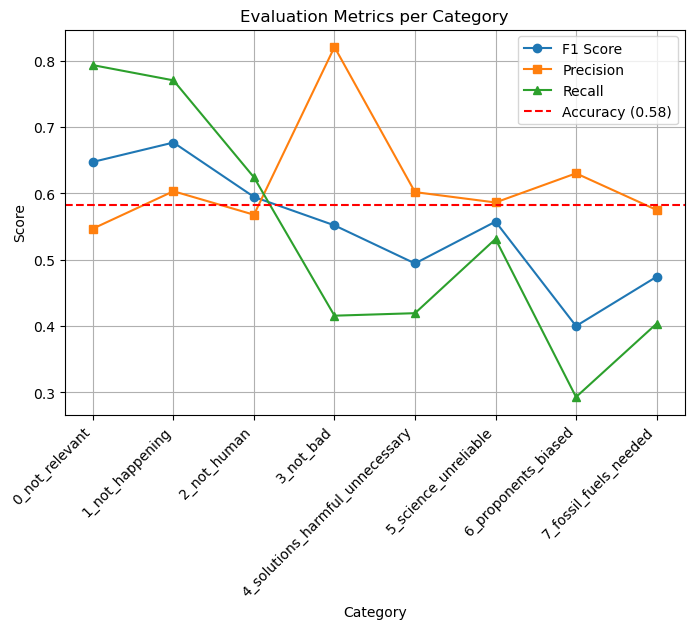

In [115]:
import numpy as np
import matplotlib.pyplot as plt

categories = metrics_df['Category']

plt.figure(figsize=(8, 5))

plt.plot(categories, metrics_df['F1 Score'], marker='o', label='F1 Score')
plt.plot(categories, metrics_df['Precision'], marker='s', label='Precision')
plt.plot(categories, metrics_df['Recall'], marker='^', label='Recall')

plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy ({accuracy:.2f})')

plt.xlabel("Category")
plt.ylabel("Score")
plt.title("Evaluation Metrics per Category")
plt.xticks(categories, le.classes_, rotation=45, ha="right")  # Align category names properly
plt.legend()
plt.grid(True)

print("Category distribution")
print(category_distribution_df)
print()
print("Category metrics")
print(metrics_df.round(2))
print()
plt.show()
print()




**Let's save the results**

In [116]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
timestamp

'2025-01-28_18:04:38'

In [117]:
filename = (
    "metrics/"
    f"{'_'.join(model_name.split('/'))}"
    f"_accuracy_{int(accuracy * 100)}"
    f"_dt_{timestamp.replace(':', '').replace('-', '')}"
    ".json"
)
filename

'metrics/RandomForestClassifier_accuracy_58_dt_20250128_180438.json'

In [118]:
note = "Baseline ML, improved preproc"

In [121]:
# ajouter category metrics

import json
import os

os.makedirs("metrics", exist_ok=True)

data = {
    "model_name": model_name,
    "timestamp": timestamp,
    "cv_accuracy": score,
    "test_accuracy": accuracy,
    "average_latency_sec": inference_time,
    "average_energy_consumption_kWh": emissions,
#    "average_power_W": average_power_W,
    "train_size" : y_train.shape[0],
    "test_size" :  y_test.shape[0],
    "note": note,
    "class_metrics": metrics_df.to_dict(orient="records")
}
data

{'model_name': 'RandomForestClassifier',
 'timestamp': '2025-01-28_18:04:38',
 'cv_accuracy': 0.5730783148752819,
 'test_accuracy': 0.5824446267432322,
 'average_latency_sec': 0.13630414009094238,
 'average_energy_consumption_kWh': 1.1375628117687175e-07,
 'train_size': 4872,
 'test_size': 1219,
 'note': 'Baseline ML, improved preproc',
 'class_metrics': [{'Category': 0,
   'Precision': 0.5468085106382978,
   'Recall': 0.7932098765432098,
   'F1 Score': 0.6473551637279596},
  {'Category': 1,
   'Precision': 0.6031746031746031,
   'Recall': 0.7702702702702703,
   'F1 Score': 0.6765578635014837},
  {'Category': 2,
   'Precision': 0.567741935483871,
   'Recall': 0.624113475177305,
   'F1 Score': 0.5945945945945946},
  {'Category': 3,
   'Precision': 0.8205128205128205,
   'Recall': 0.4155844155844156,
   'F1 Score': 0.5517241379310345},
  {'Category': 4,
   'Precision': 0.6018518518518519,
   'Recall': 0.41935483870967744,
   'F1 Score': 0.49429657794676807},
  {'Category': 5,
   'Precisi

In [ ]:
with open(filename, "w") as f:
    json.dump(data, f, indent=4)

print(f"Metrics saved to {filename}")